In [1]:
import cv2
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

In [2]:
def process_ui_image(image_path):
    # Load the color image
    image = cv2.imread(image_path)
    # Check if the image was loaded properly
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None, None, None, None  # Return four None values

    # Apply Gaussian Blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    # Convert the image to grayscale for edge detection
    gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Create a copy of the original image to draw contours
    final_image = image.copy()
    detected_components = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filter out small areas
            x, y, w, h = cv2.boundingRect(contour)
            detected_components.append((x, y, w, h))  # Store bounding box coordinates
            cv2.rectangle(final_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box
    return final_image, gray_image, edges, detected_components


In [3]:
def load_and_preprocess_images(folder_path):

    images = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg') and not filename.startswith('._'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image was successfully loaded
                img_resized = cv2.resize(img, (32, 32))
                img_normalized = img_resized.astype(np.float32) / 255.0  # Normalize image to [0, 1]
                images.append(img_normalized)

    return np.array(images)

In [4]:
def extract_labels_from_filenames(folder_path):

    class_labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg') and not filename.startswith('._'):
            label = filename.split('-')[-1].split('.')[2]  # Extract class label from filename
            component_name = label.split('.')[-1]  # Get the last part of the label
            class_labels.append(component_name)

    return class_labels

In [5]:
def load_data(folder_path):

    # Load images
    images = load_and_preprocess_images(folder_path)
    # Extract labels
    class_labels = extract_labels_from_filenames(folder_path)
    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(class_labels)
    num_classes = len(encoder.classes_)

    print(f"Loaded {len(images)} images with shape: {images.shape}")
    print(f"Encoded labels: {encoded_labels}")
    print(f"Unique classes: {encoder.classes_}")
    print(f"Number of unique classes: {num_classes}")
    print(f"Length of encoded_labels: {len(encoded_labels)}")


    return images, class_labels, encoded_labels, encoder

In [6]:
train_folder_path = '/kaggle/input/redraw-dataset-final/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Training_Sampled'

train_images, train_labels, train_labels_encoded, label_encoder = load_data(train_folder_path)
print("-------------------------------------------------------------------------------------------------")
print('Class labels: ', len(train_labels))
print('Encoded labels: ', len(train_labels_encoded))

Loaded 30518 images with shape: (30518, 32, 32, 3)
Encoded labels: [ 0  3  5 ...  4  3 15]
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'ImageView' 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 16
Length of encoded_labels: 30518
-------------------------------------------------------------------------------------------------
Class labels:  30518
Encoded labels:  30518


In [9]:
validation_folder_path = '/kaggle/input/redraw-dataset-final/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Validation_Sampled'
validation_images, validation_labels, validation_labels_encoded, _ = load_data(validation_folder_path)

print("-------------------------------------------------------------------------------------------------")
print('Class labels: ', len(validation_labels))
print('Encoded labels: ', len(validation_labels_encoded))

Loaded 28617 images with shape: (28617, 32, 32, 3)
Encoded labels: [14 14  0 ... 14  0 14]
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'ImageView' 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 16
Length of encoded_labels: 28617
-------------------------------------------------------------------------------------------------
Class labels:  28617
Encoded labels:  28617


In [12]:
test_folder_path = '/kaggle/input/redraw-dataset-final/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Test_Sampled'
test_images, test_labels, test_labels_encoded, _ = load_data(test_folder_path)

print("-------------------------------------------------------------------------------------------------")
print('Class labels: ', len(test_labels))
print('Encoded labels: ', len(test_labels_encoded))

Loaded 19086 images with shape: (19086, 32, 32, 3)
Encoded labels: [14  5  0 ... 14  5 14]
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'ImageView' 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 16
Length of encoded_labels: 19086
-------------------------------------------------------------------------------------------------
Class labels:  19086
Encoded labels:  19086


In [17]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)  # Added Dropout layer
    
    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)  # Added Dropout layer
    
    # Third Convolutional Block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)  # Increased Dropout rate
    
    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout in Dense layer
    
    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Compile Model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (32, 32, 3)  # Input image shape
num_classes = len(label_encoder.classes_)  # Number of unique classes in the dataset
model = create_cnn_model(input_shape, num_classes)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,320 (884.06 KB)

 Trainable params: 225,872 (882.31 KB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
history = model.fit(train_images, train_labels_encoded, epochs=30, batch_size=4, validation_data=(validation_images, validation_labels_encoded),verbose=1)

Epoch 1/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.2656 - loss: 2.2632 - val_accuracy: 0.5464 - val_loss: 1.5333
Epoch 2/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.4129 - loss: 1.7522 - val_accuracy: 0.6136 - val_loss: 1.3007
Epoch 3/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.4736 - loss: 1.5993 - val_accuracy: 0.4210 - val_loss: 1.5040
Epoch 4/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.5088 - loss: 1.5297 - val_accuracy: 0.6253 - val_loss: 1.1803
Epoch 5/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.5292 - loss: 1.4813 - val_accuracy: 0.6541 - val_loss: 1.1748
Epoch 6/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.5622 - loss: 1.3943 - val_accuracy: 0.6817 - val_loss: 1.0616
Epoch 7/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.5809 - loss: 1.3429 - val_accuracy: 0.6543 - val_loss: 1.0360
Epoch 8/30
7630/7630 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.5942 - loss: 1

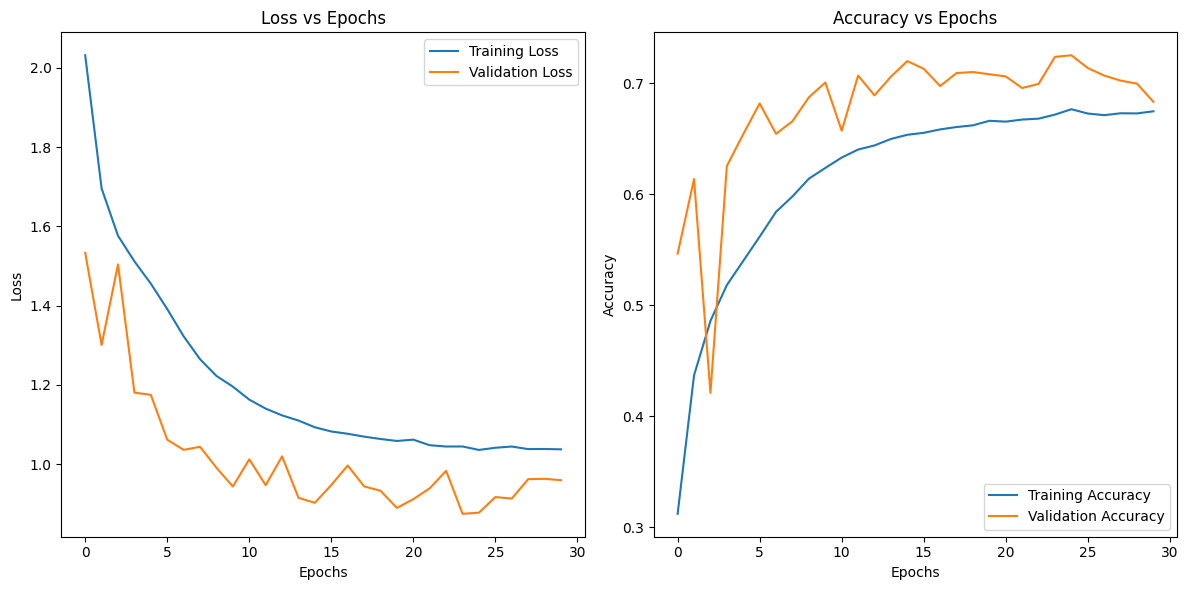

In [19]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
test_error = 1 - test_accuracy

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Error: {test_error * 100:.2f}%")

597/597 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6844 - loss: 0.9559
Test Accuracy: 68.88%
Test Error: 31.12%


In [22]:
validation_loss, validation_accuracy = model.evaluate(validation_images, validation_labels_encoded)
validation_error = 1 - validation_accuracy

print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Validation Error: {validation_error * 100:.2f}%")

895/895 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6840 - loss: 0.9520
Validation Accuracy: 68.31%
Validation Error: 31.69%


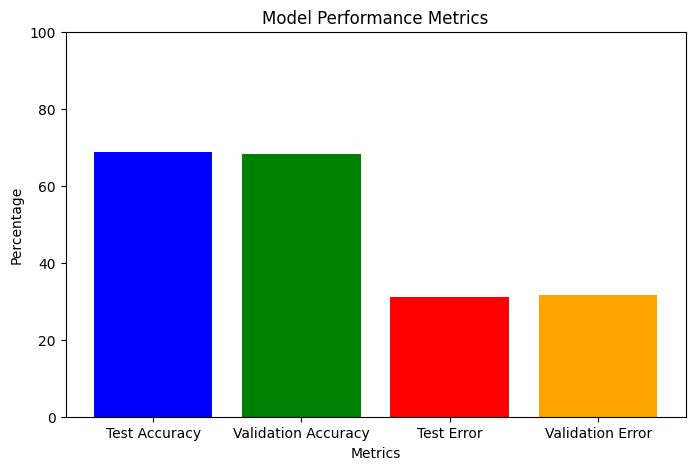

In [23]:
import matplotlib.pyplot as plt

# Data for the plot
metrics = ['Test Accuracy', 'Validation Accuracy', 'Test Error', 'Validation Error']
values = [test_accuracy * 100, validation_accuracy * 100, test_error * 100, validation_error * 100]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.title('Model Performance Metrics')
plt.ylim(0, 100)
plt.show()

In [26]:
def predict_on_test_data(test_images):

    # Predict labels for the test images
    predictions = model.predict(test_images)

    # Get the predicted class labels
    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
    return predicted_labels

# Predict labels for the test data
predicted_test_labels = predict_on_test_data(test_images)

# Print some sample predictions
print("Sample predictions on test data:", predicted_test_labels[:5])

597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Sample predictions on test data: ['TextView' 'ImageView' 'Button' 'TextView' 'TextView']


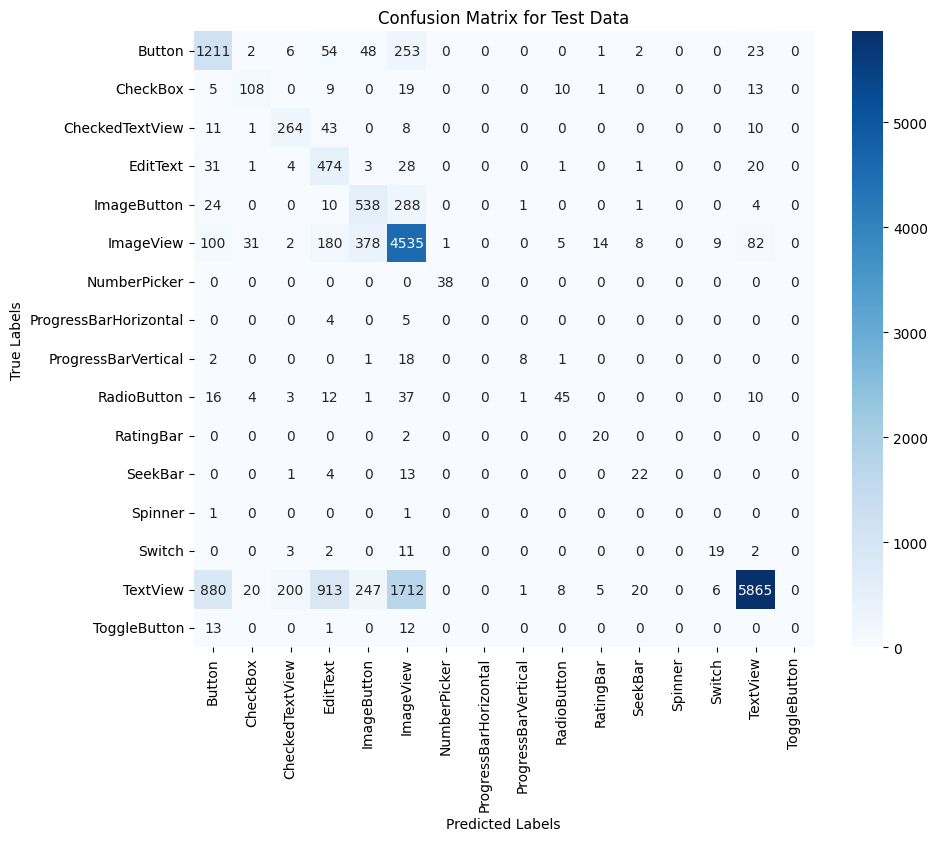

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_test_labels_str = label_encoder.transform(predicted_test_labels)

# Generate confusion matrix for the test data
cm = confusion_matrix(test_labels_encoded, predicted_test_labels_str)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Adding labels and title to the plot
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()


In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(test_labels_encoded, predicted_test_labels_str)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision with zero_division handling
precision = precision_score(test_labels_encoded, predicted_test_labels_str, average='weighted', zero_division=0)
print(f"Precision: {precision:.4f}")

# Calculate recall with zero_division handling
recall = recall_score(test_labels_encoded, predicted_test_labels_str, average='weighted', zero_division=0)
print(f"Recall: {recall:.4f}")

# Optionally, calculate F1-score with zero_division handling
f1 = f1_score(test_labels_encoded, predicted_test_labels_str, average='weighted', zero_division=0)
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6888
Precision: 0.7841
Recall: 0.6888
F1 Score: 0.7017


In [33]:
def classify_ui_components(image_path, model, encoder):
    processed_image, _, _, detected_components = process_ui_image(image_path)

    if processed_image is None:
        return None, None, None

    # Prepare images for classification
    component_images = []
    for (x, y, w, h) in detected_components:
        component_img = processed_image[y:y+h, x:x+w]
        component_img_resized = cv2.resize(component_img, (32, 32))  # Resize for CNN
        component_images.append(component_img_resized)

    if len(component_images) == 0:
        print("No components detected.")
        return [], detected_components, processed_image

    # Convert list of component images to a numpy array
    component_images_array = np.array(component_images, dtype=np.float32) / 255.0  # Normalize

    # Predict labels for each component
    predictions = model.predict(component_images_array)
    predicted_labels = encoder.inverse_transform(np.argmax(predictions, axis=1))

    return predicted_labels, detected_components, processed_image


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


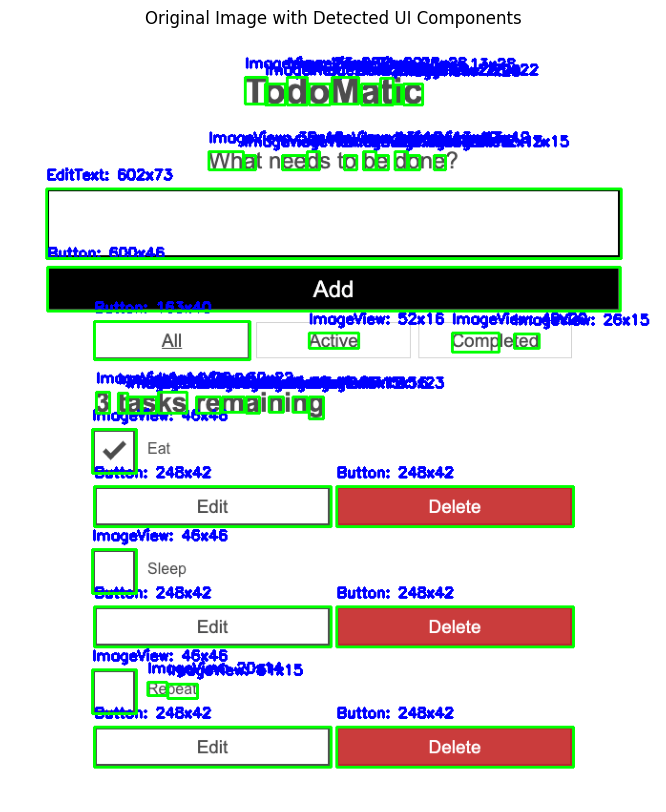

In [49]:
import cv2
import matplotlib.pyplot as plt

image_path = '/kaggle/input/test-images/images/todo.png'
predicted_labels, detected_components, processed_image = classify_ui_components(image_path, model, label_encoder)
# Display the Original Image with Bounding Boxes, Labels, and Dimensions
if processed_image is not None:
    plt.figure(figsize=(10, 10))
    # Convert to RGB for displaying in matplotlib
    image_with_boxes = processed_image.copy()

    # Create a list to hold detected components data
    detected_components_data = []

    # Draw bounding boxes, labels, and dimensions
    for (x, y, w, h), label in zip(detected_components, predicted_labels):
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box
        label_text = f"{label}: {w}x{h}"  # Label text with dimensions
        cv2.putText(image_with_boxes, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Draw label above box in red

        # Append component data to the list
        component_data = {
            "label": label,
            "bounding_box": {
                "x": x,
                "y": y,
                "width": w,
                "height": h
            }
        }
        detected_components_data.append(component_data)

    # Display the image with bounding boxes
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Detected UI Components")
    plt.axis('off')
    plt.show()
else:
    print("No processed image to display.")

In [71]:
import json
import numpy as np

def convert_detections_to_json(predicted_labels, detected_components):
    """
    Convert detected UI components and their labels to JSON format.
    
    Args:
        predicted_labels: List of predicted component labels
        detected_components: List of tuples containing (x, y, width, height)
    
    Returns:
        str: JSON string containing component information
    """
    components_data = []
    
    for label, (x, y, w, h) in zip(predicted_labels, detected_components):
        # Convert numpy values to native Python types
        component = {
            "label": str(label),  # Convert label to string
            "bounding_box": {
                "x": int(x.item() if isinstance(x, np.integer) else x),
                "y": int(y.item() if isinstance(y, np.integer) else y),
                "width": int(w.item() if isinstance(w, np.integer) else w),
                "height": int(h.item() if isinstance(h, np.integer) else h)
            }
        }
        components_data.append(component)
    
    # Convert to JSON string with proper formatting
    json_output = json.dumps(components_data, indent=2)
    return json_output

# Generate JSON
image_path = '/kaggle/input/test-images/images/todo.png'
predicted_labels, detected_components, processed_image = classify_ui_components(image_path, model, label_encoder)

if processed_image is not None:
    # Generate JSON
    json_output = convert_detections_to_json(predicted_labels, detected_components)
    print("Generated JSON:")
    print(json_output)
else:
    print("No processed image to generate JSON.")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Generated JSON:
[
  {
    "label": "Button",
    "bounding_box": {
      "x": 342,
      "y": 728,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "Button",
    "bounding_box": {
      "x": 88,
      "y": 728,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "ImageView",
    "bounding_box": {
      "x": 165,
      "y": 683,
      "width": 31,
      "height": 15
    }
  },
  {
    "label": "ImageView",
    "bounding_box": {
      "x": 144,
      "y": 681,
      "width": 20,
      "height": 14
    }
  },
  {
    "label": "ImageView",
    "bounding_box": {
      "x": 86,
      "y": 668,
      "width": 46,
      "height": 46
    }
  },
  {
    "label": "Button",
    "bounding_box": {
      "x": 342,
      "y": 602,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "Button",
    "bounding_box": {
      "x": 88,
      "y": 602,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "ImageV

In [75]:
import json
from yattag import Doc, indent
import argparse
import sys

def parse_arguments():
    """Parse arguments in a way that works with both command line and Jupyter"""
    parser = argparse.ArgumentParser(description='Convert JSON to HTML')
    parser.add_argument("--json", type=str, help="path/to/json/input")
    parser.add_argument("--html", type=str, help="path/to/html/output")
    
    # If running in Jupyter, ignore the notebook-specific arguments
    if '--json' in sys.argv:
        jupyter_args = [arg for arg in sys.argv[1:] 
                       if not arg.startswith('-f') and 
                       not arg.endswith('.json') and 
                       not arg == '-f']
        return parser.parse_args(jupyter_args)
    return parser.parse_args([])

def jsonComponentsToHtmlString(components):
    doc, tag, text = Doc().tagtext()
    doc.asis('<!DOCTYPE html>')
    with tag('html'):
        with tag('head'):
            doc.asis('<meta name="viewport" content="width=device-width, initial-scale=1.0">')
            with tag('style'):
                text('''
                    .container {
                        position: relative;
                        width: 100%;
                        height: 100vh;
                    }
                    .component {
                        position: absolute;
                        background-color: rgba(0, 123, 255, 0.3);
                        border: 1px solid rgba(0, 123, 255, 0.8);
                        display: flex;
                        justify-content: center;
                        align-items: center;
                        font-family: Arial, sans-serif;
                        font-size: 12px;
                        color: #333;
                    }
                ''')
        
        with tag('body'):
            # Create container div
            with tag('div', klass='container'):
                # Check if components is a string and try to parse it
                if isinstance(components, str):
                    try:
                        components = json.loads(components)
                    except json.JSONDecodeError:
                        raise ValueError("Invalid JSON string provided")
                
                # Handle components as a list
                if isinstance(components, list):
                    for i, component in enumerate(components):
                        if 'bounding_box' in component:
                            bbox = component['bounding_box']
                            component_style = f"""
                                top: {bbox['y']}px;
                                left: {bbox['x']}px;
                                width: {bbox['width']}px;
                                height: {bbox['height']}px;
                            """.replace("\n", "")
                            
                            with tag('div', klass='component', style=component_style, id=f'element-{i}'):
                                if 'label' in component:
                                    text(component['label'])
                
    return indent(doc.getvalue())

def jsonToHtml(json_data=None, json_path=None, output_html_file="output.html"):
    """Convert JSON to HTML. Accept either direct JSON data or a path to JSON file."""
    if json_data is not None:
        components = json_data
    elif json_path is not None:
        try:
            with open(json_path, "r") as jsonfile:
                components = json.load(jsonfile)
        except json.JSONDecodeError:
            raise ValueError(f"Invalid JSON file: {json_path}")
    else:
        raise ValueError("Either json_data or json_path must be provided")
        
    htmlString = jsonComponentsToHtmlString(components)
    
    if output_html_file:
        with open(output_html_file, "w", encoding='utf-8') as out_html:
            out_html.write(htmlString)
    
    return htmlString

# Example usage

# For direct usage in Jupyter:
if __name__ == "__main__":
    try:
        args = parse_arguments()
        if args.json:
            jsonToHtml(json_path=args.json, output_html_file=args.html or "output.html")
        else:
            # Use example data if no input provided
            print(jsonToHtml(json_data=json_output, output_html_file="output.html"))
    except Exception as e:
        print(f"Error: {str(e)}")

<!DOCTYPE html>
<html>
  <head>
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
                    .container {
                        position: relative;
                        width: 100%;
                        height: 100vh;
                    }
                    .component {
                        position: absolute;
                        background-color: rgba(0, 123, 255, 0.3);
                        border: 1px solid rgba(0, 123, 255, 0.8);
                        display: flex;
                        justify-content: center;
                        align-items: center;
                        font-family: Arial, sans-serif;
                        font-size: 12px;
                        color: #333;
                    }
                </style>
  </head>
  <body>
    <div class="container">
      <div class="component" style="                                top: 728px;                                left: 342px;             